#  Project Title: Predictive Modeling of Bioreactor Performance Using Multi-Batch Time Series Data

### Project Description

This project develops a machine learning pipeline to predict critical fermentation outcomes using multi-batch, multi-sensor time series data from a biomanufacturing process.

The dataset includes:

- 35 distinct fermentation batches (SAP)
- 20 unique process sensor features (TagID), such as dissolved oxygen, agitation current, tank weight, pressure, and temperature
- Over 625,000 time-stamped observations, recorded at a high frequency of every ~0.033 hours (approximately every 2 minutes)

Each batch captures the evolution of process dynamics over time, with measurements structured in long format and reshaped into wide format for modeling. The Age column provides a continuous time reference, allowing each sensor reading to be aligned across batches.

### 🧠 Modeling Strategy

A global machine learning modeling framework is applied across all 35 batches to establish a "golden batch" baseline that captures typical fermentation behavior.

Multiple regression algorithms are explored, including:
- Random Forest Regressor
- Gradient Boosting (e.g., XGBoost, LightGBM)
- ElasticNet / Ridge Regression
- (Optionally) Time-aware models like Temporal Convolutional Networks (TCNs) in future iterations

Model performance is evaluated using R² and MAE, both overall and per batch, to assess generalization and robustness across varying process conditions.

SHAP (SHapley Additive Explanations) is used to interpret feature importance and detect shifts in critical process drivers between batches.

This global model serves as a "golden reference", enabling comparison against new or future batches for early drift detection and quality control.

### 🔧 Technical Stack

- pandas: data reshaping (long to wide), cleaning
- scikit-learn, XGBoost, LightGBM: modeling and evaluation
- SHAP: interpretability and feature importance analysis
- MLflow: experiment tracking, model comparison, and deployment versioning
- Streamlit (planned): interactive batch explorer dashboard with predictions and SHAP explanations

## Step 1: Load + Inspect Raw Data

In [1]:
pip install xgboost lightgbm shap

Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
# Correct file name and function
file_path = "B100_cP_4000_L_data_02Aug2024.csv"
df_raw = pd.read_csv(file_path)

df_raw.head()


,Process_Step,SAP,EquipmentID,Timestamp,Fermentation,Age,TagID,Value,Last_Updated
0,4000-L Fermenter,NCDCA4426,FER-31131,2022-11-22 10:49:19.000,True,0.0,Acid_Tank_Weight,120.889000,2023-11-29 18:00:06.000
1,4000-L Fermenter,NCDCA4426,FER-31131,2022-11-22 10:49:19.000,True,0.0,Agitator_VFD_Current_Value,45.999996,2023-11-29 18:00:06.000
2,4000-L Fermenter,NCDCA4426,FER-31131,2022-11-22 10:49:19.000,True,0.0,Airflow_Current_Value,600.000000,2023-11-29 18:00:06.000
3,4000-L Fermenter,NCDCA4426,FER-31131,2022-11-22 10:49:19.000,True,0.0,Antifoam_Tank_Temperature,43.328940,2023-11-29 18:00:06.000
4,4000-L Fermenter,NCDCA4426,FER-31131,2022-11-22 10:49:19.000,True,0.0,Antifoam_Tank_Weight,32.430000,2023-11-29 18:00:06.000


### Data exploration

In [57]:
# Print number of distinct values for each column
print("🔍 Number of distinct values per column:\n")
for col in df_raw.columns:
    unique_count = df_raw[col].nunique(dropna=True)
    print(f"{col}: {unique_count}")

🔍 Number of distinct values per column:

Process_Step: 1
SAP: 35
EquipmentID: 3
Timestamp: 48772
Fermentation: 2
Age: 1639
TagID: 20
Value: 625372
Last_Updated: 11


In [58]:
unique_tagids = df_raw["TagID"].dropna().unique()
print(f"🔹 TagID column — {len(unique_tagids)} unique values:")
print(unique_tagids)

🔹 TagID column — 20 unique values:
['Acid_Tank_Weight' 'Agitator_VFD_Current_Value' 'Airflow_Current_Value'
 'Antifoam_Tank_Temperature' 'Antifoam_Tank_Weight'
 'cP_Supplement_Tank_Weight' 'Dissolved_Oxygen' 'Fermentor_pH_Probe_A'
 'Fermentor_pH_Probe_B' 'Fermentor_Skid_Pressure'
 'Fermentor_Skid_Temperature' 'Fermentor_Weight' 'Gas_Analyzer_CER Ratio'
 'Gas_Analyzer_OUR Ratio' 'Glutamate_Concentration'
 'Glutamate_Concentration_DMODX' 'Jacket_Temperature' 'Oxygen Gas (%)'
 'Seal_Pressure_Controller' 'Voltage_Foam_Echo_Amplitude']


##  Step 2: Clean

### Drop irrelevant columns

In [59]:
cols_to_drop = ["Process_Step", "EquipmentID", "Fermentation", "Last_Updated","Timestamp"]
df_raw = df_raw.drop(columns=[col for col in cols_to_drop if col in df_raw.columns])
df_raw.head()

,SAP,Age,TagID,Value
0,NCDCA4426,0.0,Acid_Tank_Weight,120.889000
1,NCDCA4426,0.0,Agitator_VFD_Current_Value,45.999996
2,NCDCA4426,0.0,Airflow_Current_Value,600.000000
3,NCDCA4426,0.0,Antifoam_Tank_Temperature,43.328940
4,NCDCA4426,0.0,Antifoam_Tank_Weight,32.430000


### Check % of missing columns & Drop missing columns

In [60]:
# Total rows
total_rows = len(df_raw)

# Count missing in each
missing_tagid = df_raw["TagID"].isnull().sum()
missing_value = df_raw["Value"].isnull().sum()

print(f"Missing TagID: {missing_tagid} rows ({100 * missing_tagid / total_rows:.2f}%)")
print(f"Missing Value: {missing_value} rows ({100 * missing_value / total_rows:.2f}%)")

Missing TagID: 0 rows (0.00%)
Missing Value: 13772 rows (1.41%)


In [61]:
df_clean = df_raw.dropna(subset=["TagID", "Value"])

### Pivot to wide format

In [62]:
# === Pivot to wide format ===
df_pivot = df_clean.pivot_table(
    index=["SAP", "Age"],
    columns="TagID",
    values="Value"
).reset_index()
df_pivot.head()

TagID,SAP,Age,Acid_Tank_Weight,Agitator_VFD_Current_Value,Airflow_Current_Value,Antifoam_Tank_Temperature,Antifoam_Tank_Weight,Dissolved_Oxygen,Fermentor_Skid_Pressure,Fermentor_Skid_Temperature,...,Fermentor_pH_Probe_B,Gas_Analyzer_CER Ratio,Gas_Analyzer_OUR Ratio,Glutamate_Concentration,Glutamate_Concentration_DMODX,Jacket_Temperature,Oxygen Gas (%),Seal_Pressure_Controller,Voltage_Foam_Echo_Amplitude,cP_Supplement_Tank_Weight
0,3CA3489,0.000000,146.370987,62.018430,153.000000,29.106360,36.970000,63.992100,0.143882,36.060425,...,7.192805,0.0,0.433216,0.0,0.0,35.992490,20.198816,19.732876,6.616014,249.032669
1,3CA3489,0.033333,146.373215,62.307884,106.500000,29.106950,36.743336,12.113700,0.065651,36.076748,...,7.191095,0.0,0.433216,0.0,0.0,36.433960,20.025131,19.812042,4.452748,249.040054
2,3CA3489,0.066667,146.361000,62.594276,106.625000,29.102137,36.730000,2.086756,0.065615,36.083534,...,7.189330,0.0,0.219999,0.0,0.0,35.703674,19.851448,18.743958,4.528327,249.047455
3,3CA3489,0.100000,146.389038,62.880634,106.399994,29.107002,36.728573,8.575014,0.065579,36.046360,...,7.187338,0.0,0.429186,0.0,0.0,35.438560,19.660587,16.753440,4.511223,249.054855
4,3CA3489,0.133333,146.376251,63.166912,107.000000,29.100983,36.745937,12.184182,0.065542,36.007553,...,7.183259,0.0,0.399185,0.0,0.0,35.169280,19.469583,16.545090,4.587913,249.062241


### Check the value distribution & missing 

In [63]:
df_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
TagID,,,,,,,,
Age,48772.0,24.546484,14.443737,0.000000,12.033333,24.366667,36.900000,54.600000
Acid_Tank_Weight,48772.0,93.355154,44.457622,-4.836667,55.209500,105.160250,135.371250,151.338989
Agitator_VFD_Current_Value,48772.0,126.075607,26.815152,0.000000,123.553176,135.575883,135.800000,163.798584
Airflow_Current_Value,48772.0,217.435082,95.238705,0.000000,133.172081,189.816664,320.600000,672.000000
Antifoam_Tank_Temperature,48772.0,28.104131,3.482669,21.620628,25.540499,27.683007,29.255927,49.252098
Antifoam_Tank_Weight,48772.0,24.470816,6.960074,-1.595000,19.506590,26.114188,29.960001,37.188000
Dissolved_Oxygen,48770.0,27.616050,17.399797,-2.337377,16.627395,26.747576,36.672319,219.931534
Fermentor_Skid_Pressure,48772.0,0.257650,1.379055,-3.156886,0.059781,0.122339,0.214151,28.601942
Fermentor_Skid_Temperature,48772.0,35.354698,3.996391,6.756274,35.974829,35.998660,36.015797,126.807007


Most features show reasonable ranges and distributions. Dissolved_Oxygen, pH, temperature, and agitation values appear consistent with expected process behavior. A few features like Glutamate_Concentration have extreme negative values, which may indicate sensor noise or errors. Fermentor_Weight has a wide range but is likely valid. Two Gas_Analyzer features show ~14% missingness and were excluded. No major outliers or invalid features remain, making the dataset suitable for modeling.

### Set negatives to NaN (safer for modeling)

In [64]:
# Option A: Set negatives to NaN (safer for modeling)
df_pivot["Dissolved_Oxygen"] = df_pivot["Dissolved_Oxygen"].mask(df_pivot["Dissolved_Oxygen"] < 0)
df_pivot["Glutamate_Concentration"] = df_pivot["Glutamate_Concentration"].mask(df_pivot["Glutamate_Concentration"] < 0)

### Check for zero variance & drop

In [65]:
constant_cols = [col for col in df_pivot.columns if df_pivot[col].nunique() <= 1]

# Print result
print(f"🔍 Found {len(constant_cols)} constant columns:")
print(constant_cols)

🔍 Found 0 constant columns:
[]


### Drop TAGID columns with significant missing values

Dropping Gas_Analyzer_OUR Ratio and CER Ratio due to high missingness (14%)and Glutamate_Concentration (36%) and limited value for DO prediction. These derived metrics may also cause data leakage and are not essential in the first model version.

In [66]:
# Show % of missing values
missing_pct = df_pivot.isnull().mean().sort_values(ascending=False) * 100
display(missing_pct[missing_pct > 0].round(2))

TagID
Glutamate_Concentration        36.53
Gas_Analyzer_OUR Ratio         14.11
Gas_Analyzer_CER Ratio         14.11
Dissolved_Oxygen                2.02
Voltage_Foam_Echo_Amplitude     0.00
dtype: float64

In [67]:
df_pivot = df_pivot.drop(columns=["Gas_Analyzer_OUR Ratio", "Gas_Analyzer_CER Ratio","Glutamate_Concentration"])

In [68]:
# Function to count outliers in a single column
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

# Apply to all TagID features (exclude metadata columns)
metadata_cols = ["SAP", "Age", "Timestamp", "BatchID"] if "BatchID" in df_pivot.columns else ["SAP", "Age"]
tagid_cols = [col for col in df_pivot.columns if col not in metadata_cols]

# Count outliers
outlier_summary = {
    col: count_outliers_iqr(df_pivot[col]) for col in tagid_cols
}

# Convert to DataFrame and show
import pandas as pd
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["Outlier_Count"])
outlier_df["Outlier_%"] = (outlier_df["Outlier_Count"] / len(df_pivot) * 100).round(2)
outlier_df = outlier_df.sort_values("Outlier_%", ascending=False)

print("🔍 Outlier summary for all TagID features:")
display(outlier_df)


🔍 Outlier summary for all TagID features:


,Outlier_Count,Outlier_%
Fermentor_pH_Probe_A,15465,31.71
Fermentor_Skid_Temperature,14166,29.05
Agitator_VFD_Current_Value,9523,19.53
Glutamate_Concentration_DMODX,5502,11.28
Fermentor_pH_Probe_B,3830,7.85
Jacket_Temperature,3253,6.67
Antifoam_Tank_Temperature,2481,5.09
Fermentor_Skid_Pressure,2415,4.95
Voltage_Foam_Echo_Amplitude,2147,4.40
Dissolved_Oxygen,1819,3.73


Outlier analysis shows that most features have low outlier rates (<10%), while a few—such as Fermentor_pH_Probe_A, Skid_Temperature, and Agitator_VFD—exceed 20–30%, likely due to noise or batch-specific spikes. For comparison, we selected four features with moderate to high outlier percentages and applied both masking (set to NaN) and clipping (limit to IQR range). This allows us to evaluate which strategy better preserves signal while maintaining model performance for DO prediction.



In [69]:
features_to_handle = [
    "Dissolved_Oxygen", 
    "Fermentor_pH_Probe_A", 
    "Fermentor_Skid_Temperature", 
    "Agitator_VFD_Current_Value"
]

In [70]:
import numpy as np

def handle_outliers(df, strategy="mask", features=[]):
    df_copy = df.copy()
    for col in features:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        if strategy == "mask":
            df_copy[col] = df_copy[col].where((df_copy[col] >= lower) & (df_copy[col] <= upper))
        elif strategy == "clip":
            df_copy[col] = df_copy[col].clip(lower=lower, upper=upper)
    return df_copy

# Apply both
df_masked = handle_outliers(df_pivot, strategy="mask", features=features_to_handle)
df_clipped = handle_outliers(df_pivot, strategy="clip", features=features_to_handle)

In [71]:
print("🔍 Final Shape Check")
print(f"df_masked:  {df_masked.shape}")
print(f"df_clipped: {df_clipped.shape}")
print("📉 Missing value % (Masked)")
display((df_masked.isnull().mean() * 100).round(2).sort_values(ascending=False).head(10))

print("📉 Missing value % (Clipped)")
display((df_clipped.isnull().mean() * 100).round(2).sort_values(ascending=False).head(10))

🔍 Final Shape Check
df_masked:  (48772, 19)
df_clipped: (48772, 19)
📉 Missing value % (Masked)


TagID
Fermentor_pH_Probe_A             31.71
Fermentor_Skid_Temperature       29.05
Agitator_VFD_Current_Value       19.53
Dissolved_Oxygen                  5.75
Voltage_Foam_Echo_Amplitude       0.00
Seal_Pressure_Controller          0.00
Oxygen Gas (%)                    0.00
Jacket_Temperature                0.00
Glutamate_Concentration_DMODX     0.00
Fermentor_pH_Probe_B              0.00
dtype: float64

📉 Missing value % (Clipped)


TagID
Dissolved_Oxygen                 2.02
SAP                              0.00
Fermentor_Weight                 0.00
Voltage_Foam_Echo_Amplitude      0.00
Seal_Pressure_Controller         0.00
Oxygen Gas (%)                   0.00
Jacket_Temperature               0.00
Glutamate_Concentration_DMODX    0.00
Fermentor_pH_Probe_B             0.00
Fermentor_pH_Probe_A             0.00
dtype: float64

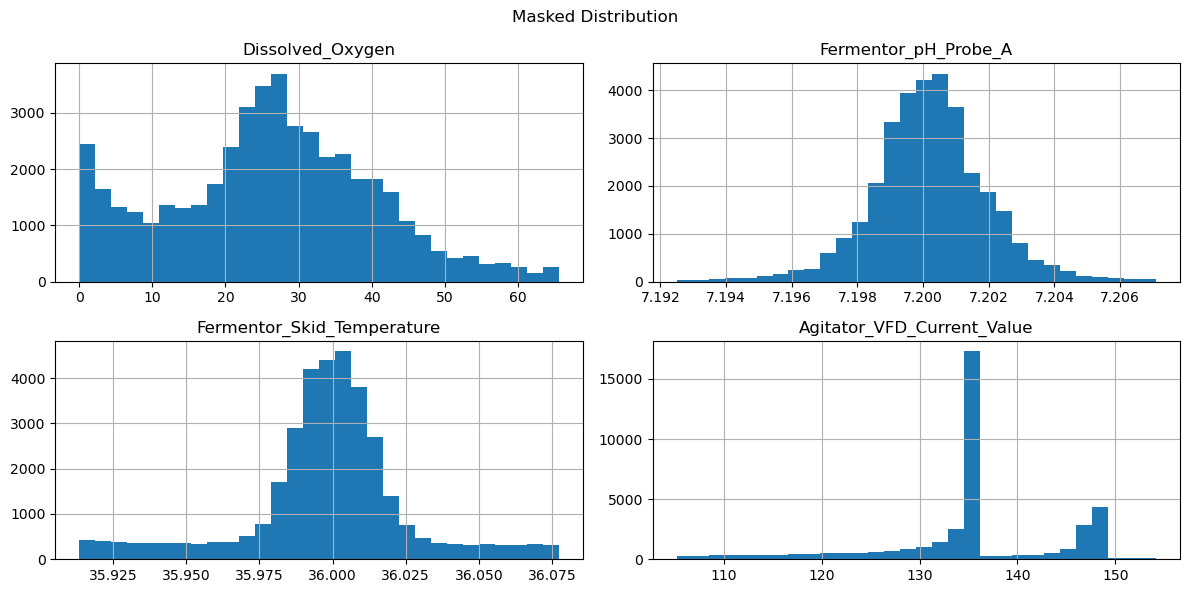

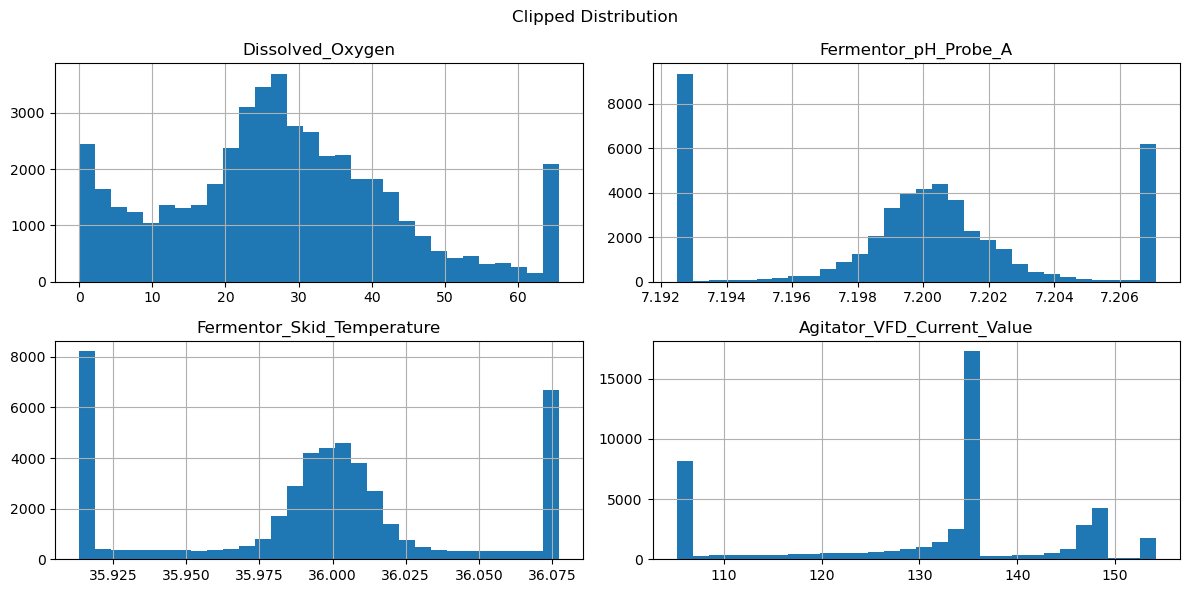

In [18]:
df_masked[features_to_handle].hist(bins=30, figsize=(12, 6), layout=(2, 2))
plt.suptitle("Masked Distribution")
plt.tight_layout()
plt.show()

df_clipped[features_to_handle].hist(bins=30, figsize=(12, 6), layout=(2, 2))
plt.suptitle("Clipped Distribution")
plt.tight_layout()
plt.show()

The dataset is now clean and ready for modeling. Outliers in key features were handled using both masking and clipping, with distributions validated post-cleaning. Missing values are within acceptable limits, and all constant or high-missing columns were removed. Both df_masked and df_clipped are structured, consistent, and suitable for training.

In [54]:
df_clipped.to_csv("data/df_clipped_v1.csv", index=False)

# Experiment 1: Dissolved_Oxygen

## Step 3: Feature & Target Selection

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

def train_model_flex(X, y, model, scale=True, impute=True):
    # Copy to avoid modifying original
    X = X.copy()
    y = y.copy()

    # ✅ Always drop rows with NaN in y
    valid_y = y.notnull()
    X = X[valid_y]
    y = y[valid_y]

    # ✅ Drop rows with NaNs in X only if the model doesn't support them
    if not isinstance(model, HistGradientBoostingRegressor):
        valid_X = X.notnull().all(axis=1)
        X = X[valid_X]
        y = y.loc[X.index]  # sync index

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Build pipeline
    steps = []
    if impute:
        steps.append(("imputer", SimpleImputer(strategy="median")))
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("model", model))

    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return {
        "model": pipeline,
        "r2": r2,
        "mae": mae,
        "y_test": y_test,
        "y_pred": y_pred
    }


## Step 4: Model Training + Evaluation

In [20]:
# Choose which cleaned version to test
df_use = df_clipped  # or df_masked

# Feature + target
X = df_use.drop(columns=["SAP", "Age", "Dissolved_Oxygen"])
y = df_use["Dissolved_Oxygen"]

# Import models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Initialize results dictionary
results = {}

# Train all models using unified pipeline
results["Random Forest"] = train_model_flex(X, y, RandomForestRegressor(n_estimators=100))
results["Ridge Regression"] = train_model_flex(X, y, Ridge(alpha=1.0))
results["SVR"] = train_model_flex(X, y, SVR(kernel="rbf", C=1.0))
results["HGBR"] = train_model_flex(X, y, HistGradientBoostingRegressor())
results["XGBoost"] = train_model_flex(X, y, XGBRegressor(n_estimators=100), scale=False, impute=False)
results["LightGBM"] = train_model_flex(X, y, LGBMRegressor(n_estimators=100), scale=False, impute=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 38228, number of used features: 16
[LightGBM] [Info] Start training from score 27.773419


In [21]:
import pandas as pd

summary = pd.DataFrame({
    name: {
        "R²": result["r2"],
        "MAE": result["mae"]
    } for name, result in results.items()
}).T.round(3).sort_values("R²", ascending=False)

display(summary)


,R²,MAE
Random Forest,0.974,1.213
XGBoost,0.966,1.815
LightGBM,0.947,2.376
HGBR,0.944,2.440
SVR,0.731,5.335
Ridge Regression,0.265,10.293


In [22]:
strong_models = ["Random Forest", "XGBoost", "LightGBM", "HGBR"]

summary_filtered = pd.DataFrame({
    name: {
        "R²": result["r2"],
        "MAE": result["mae"]
    } for name, result in results.items() if name in strong_models
}).T.round(3)

display(summary_filtered)


,R²,MAE
Random Forest,0.974,1.213
HGBR,0.944,2.440
XGBoost,0.966,1.815
LightGBM,0.947,2.376


Random Forest R²: 0.9736
Random Forest MAE: 1.2129


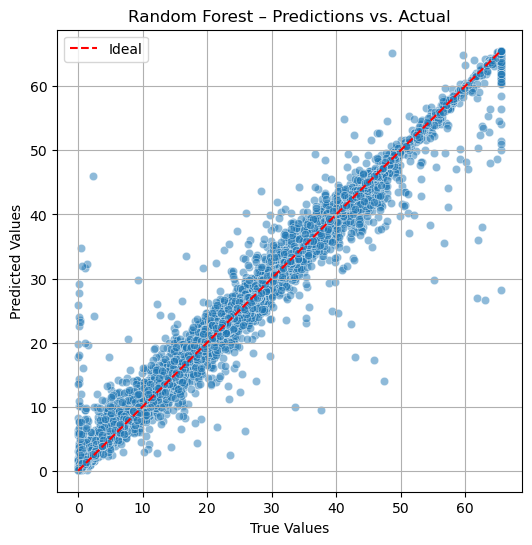

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

def plot_predictions(results, model_name="Random Forest"):
    y_test = results[model_name]["y_test"]
    y_pred = results[model_name]["y_pred"]
    
    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print metrics
    print(f"{model_name} R²: {r2:.4f}")
    print(f"{model_name} MAE: {mae:.4f}")
    
    # Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} – Predictions vs. Actual")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_predictions(results, "Random Forest")


##  Step 5: SHAP Interpretability

In [39]:
def plot_shap(model_pipeline, X, title="SHAP Summary", max_samples=100):
    import shap
    model = model_pipeline.named_steps["model"]
    preprocessor = model_pipeline[:-1]
    X_proc = preprocessor.transform(X)
    explainer = shap.TreeExplainer(model)
    X_sample = X_proc[:max_samples] if hasattr(X_proc, '__getitem__') else X_proc.to_numpy()[:max_samples]
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=X.columns)


In [46]:
def plot_shap(model_pipeline, X, title="SHAP Summary", max_samples=100):
    import shap

    model = model_pipeline.named_steps["model"]

    # If pipeline has preprocessing
    if len(model_pipeline.steps) > 1:
        preprocessor = model_pipeline[:-1]
        X_proc = preprocessor.transform(X)
    else:
        X_proc = X.copy()

    explainer = shap.TreeExplainer(model)
    X_sample = X_proc[:max_samples] if hasattr(X_proc, '__getitem__') else X_proc.to_numpy()[:max_samples]
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, feature_names=X.columns)
    
    return shap_values, X_proc


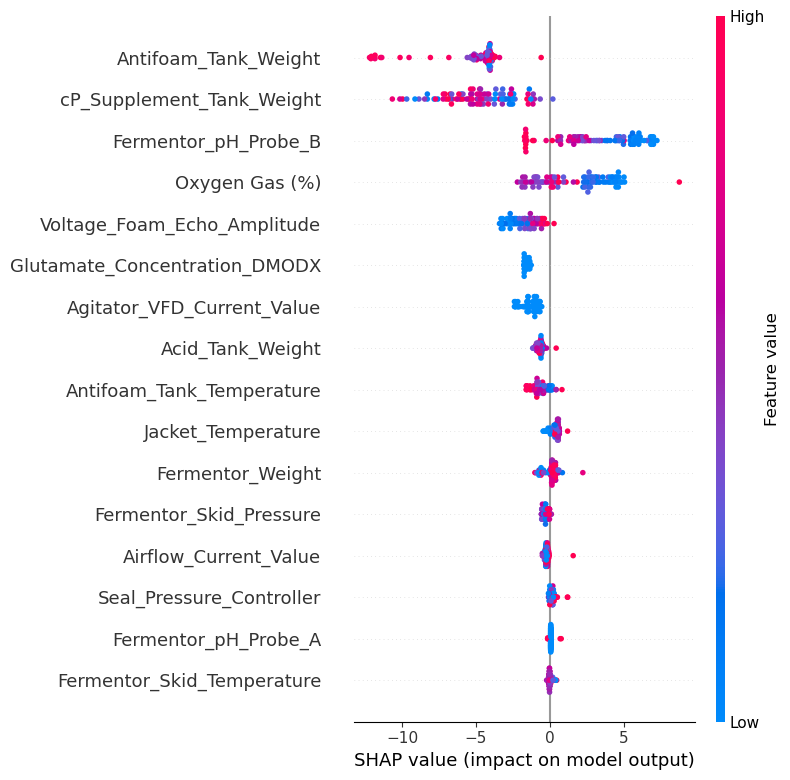

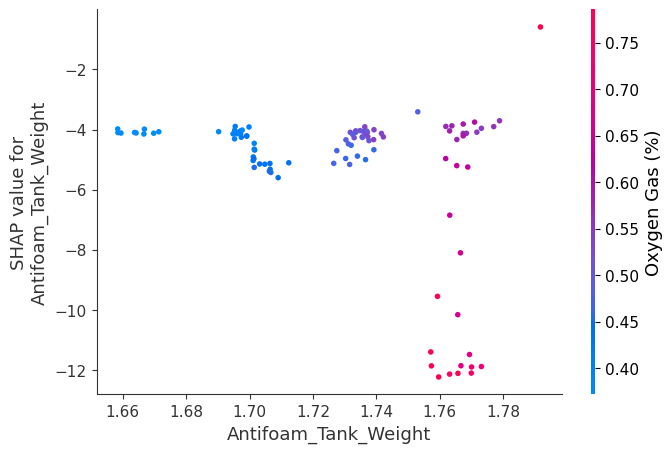

In [50]:
# Slice the same subset of X used for SHAP
X_sample = X.iloc[:100]
shap_values, X_proc_sample = plot_shap(results["Random Forest"]["model"], X_sample, max_samples=100)

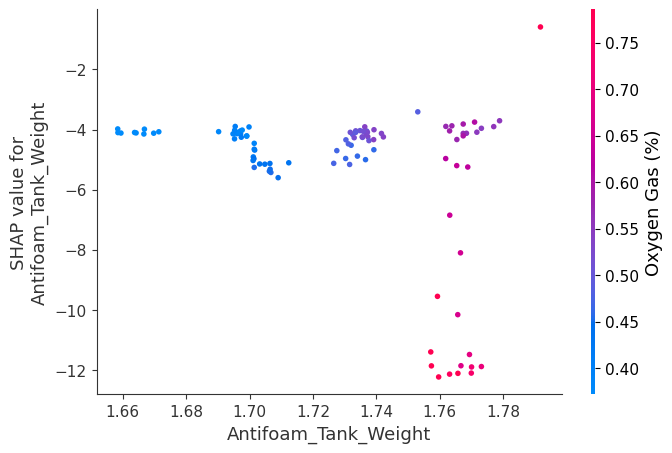

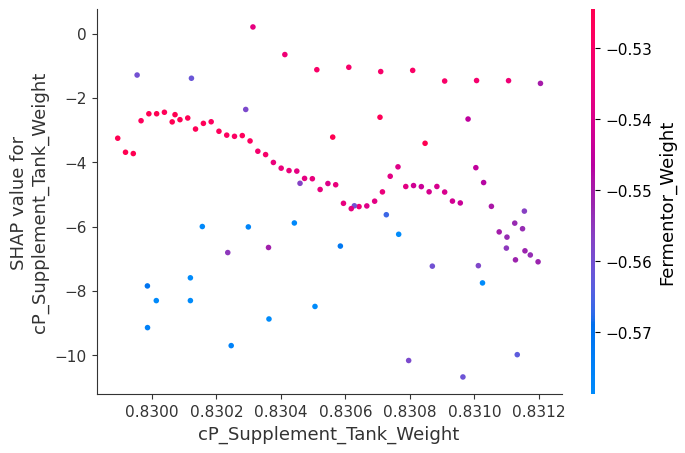

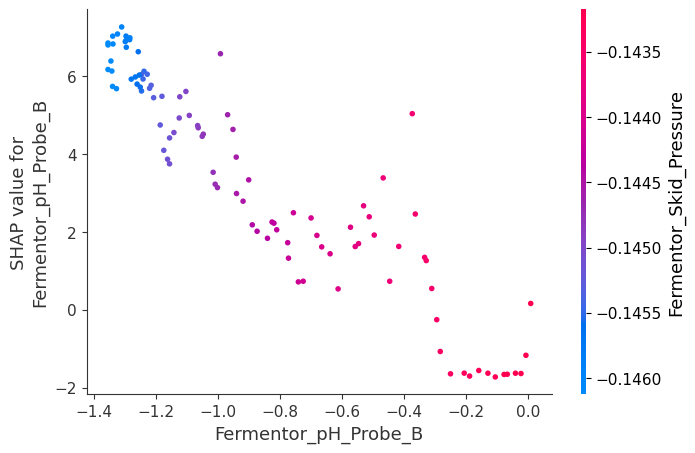

In [52]:
top_features = ["Antifoam_Tank_Weight", "cP_Supplement_Tank_Weight", "Fermentor_pH_Probe_B"]

for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_proc_sample, feature_names=X_sample.columns)


# Experiment 2: Fermentor_pH_Probe_B

In [74]:
# Choose which cleaned version to test
df_use = df_clipped  # or df_masked

# Feature + target
X = df_use.drop(columns=["SAP", "Age", "Fermentor_pH_Probe_B"])
y = df_use["Fermentor_pH_Probe_B"]

# Import models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Initialize results dictionary
results = {}

# Train all models using unified pipeline
results["Random Forest"] = train_model_flex(X, y, RandomForestRegressor(n_estimators=100))
results["Ridge Regression"] = train_model_flex(X, y, Ridge(alpha=1.0))
results["SVR"] = train_model_flex(X, y, SVR(kernel="rbf", C=1.0))
results["HGBR"] = train_model_flex(X, y, HistGradientBoostingRegressor())
results["XGBoost"] = train_model_flex(X, y, XGBRegressor(n_estimators=100), scale=False, impute=False)
results["LightGBM"] = train_model_flex(X, y, LGBMRegressor(n_estimators=100), scale=False, impute=False)

# Summary table
import pandas as pd

summary = pd.DataFrame({
    name: {
        "R²": result["r2"],
        "MAE": result["mae"]
    } for name, result in results.items()
}).T.round(3).sort_values("R²", ascending=False)

display(summary)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 38228, number of used features: 16
[LightGBM] [Info] Start training from score 7.191918


,R²,MAE
Random Forest,0.990,0.002
XGBoost,0.986,0.006
LightGBM,0.972,0.009
HGBR,0.960,0.010
SVR,0.687,0.051
Ridge Regression,0.284,0.062


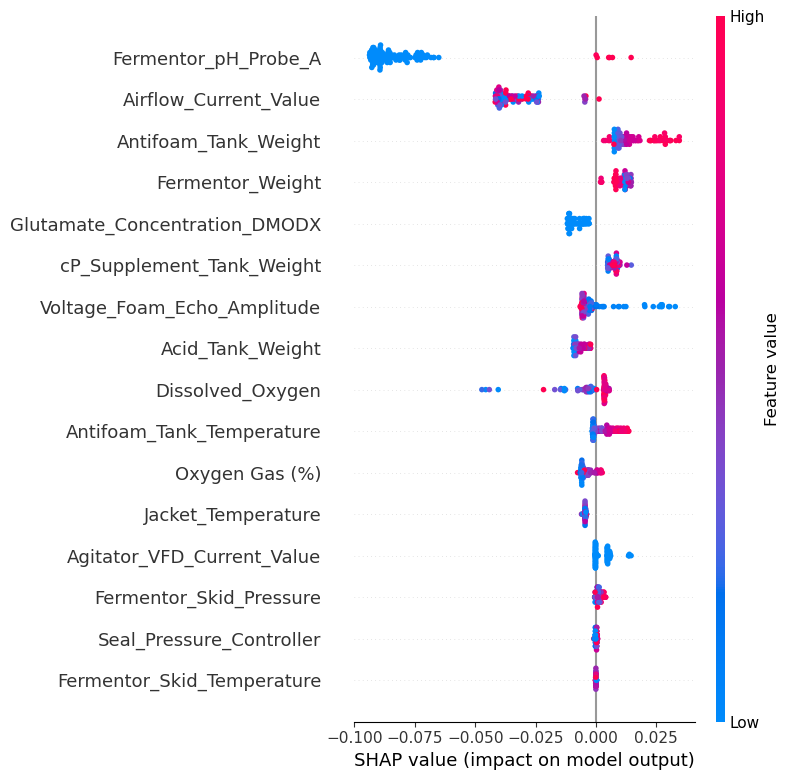

In [75]:
shap_values_ph, X_proc_ph = plot_shap(results["Random Forest"]["model"], X)


# 🔁 Experiment 3: Fermentor_Skid_Pressure

In [76]:
# Choose which cleaned version to test
df_use = df_clipped  # or df_masked

# Feature + target
X = df_use.drop(columns=["SAP", "Age", "Fermentor_Skid_Pressure"])
y = df_use["Fermentor_Skid_Pressure"]

# Import models (only if not already imported above)
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Initialize results dictionary
results = {}

# Train all models using unified pipeline
results["Random Forest"] = train_model_flex(X, y, RandomForestRegressor(n_estimators=100))
results["Ridge Regression"] = train_model_flex(X, y, Ridge(alpha=1.0))
results["SVR"] = train_model_flex(X, y, SVR(kernel="rbf", C=1.0))
results["HGBR"] = train_model_flex(X, y, HistGradientBoostingRegressor())
results["XGBoost"] = train_model_flex(X, y, XGBRegressor(n_estimators=100), scale=False, impute=False)
results["LightGBM"] = train_model_flex(X, y, LGBMRegressor(n_estimators=100), scale=False, impute=False)

# Summary table
import pandas as pd

summary = pd.DataFrame({
    name: {
        "R²": result["r2"],
        "MAE": result["mae"]
    } for name, result in results.items()
}).T.round(3).sort_values("R²", ascending=False)

display(summary)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 38228, number of used features: 16
[LightGBM] [Info] Start training from score 0.222437


,R²,MAE
Random Forest,0.993,0.005
XGBoost,0.991,0.014
LightGBM,0.988,0.025
HGBR,0.978,0.031
SVR,0.811,0.063
Ridge Regression,0.279,0.435


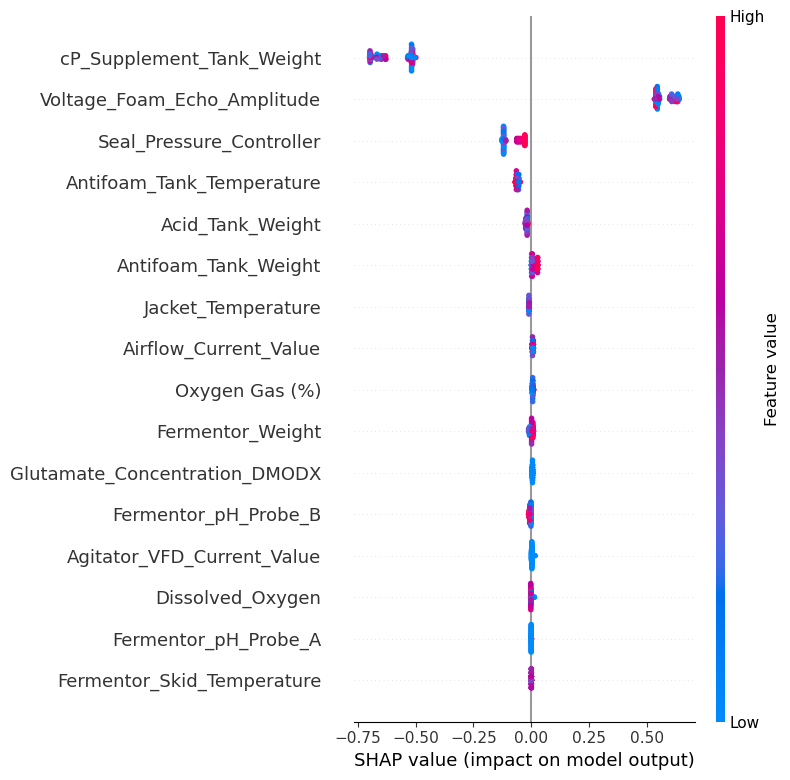

In [77]:
# SHAP summary for Fermentor_Skid_Pressure (Random Forest)
shap_values_pressure, X_proc_pressure = plot_shap(results["Random Forest"]["model"], X)
